In [32]:

import torch
import torchvision.transforms as T
from PIL import Image

from featup.util import norm, unnorm

from hr_dv2.utils import *
import hr_dv2.transform as tr
from hr_dv2 import torch_pca

import matplotlib.pyplot as plt

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_norm = True

In [34]:
path = "data/plant.png"
_img = Image.open(path)
_h, _w = _img.height, _img.width
t = tr.closest_crop(_h, _w, 14, True)

t = tr.get_input_transform(224, 224)

img_tensor, img = tr.load_image(path, t)
img_arr = np.array(img)
h, w, c = img_arr.shape


img_tensor.to(torch.float16)
img_tensor = img_tensor.to(device)
img_tensor = img_tensor.unsqueeze(0)

In [35]:
print(img_tensor.shape)

torch.Size([1, 3, 224, 224])


In [36]:
upsampler = torch.hub.load("mhamilton723/FeatUp", 'vit', use_norm=use_norm).to(device)
hr_feats = upsampler(img_tensor)
lr_feats = upsampler.model(img_tensor)
print(hr_feats.shape)

Using cache found in /home/ronan/.cache/torch/hub/mhamilton723_FeatUp_main


torch.Size([1, 384, 224, 224])


In [37]:
img_tensor = img_tensor.to('cpu')

In [38]:
feats_np = tr.to_numpy(hr_feats)

In [39]:
print(feats_np.shape)

(384, 224, 224)


In [40]:
feats_flat = tr.flatten(feats_np, 224, 224, 384)
pcaed = do_single_pca(feats_flat)

In [41]:
rescaled = rescale_pca(pcaed)

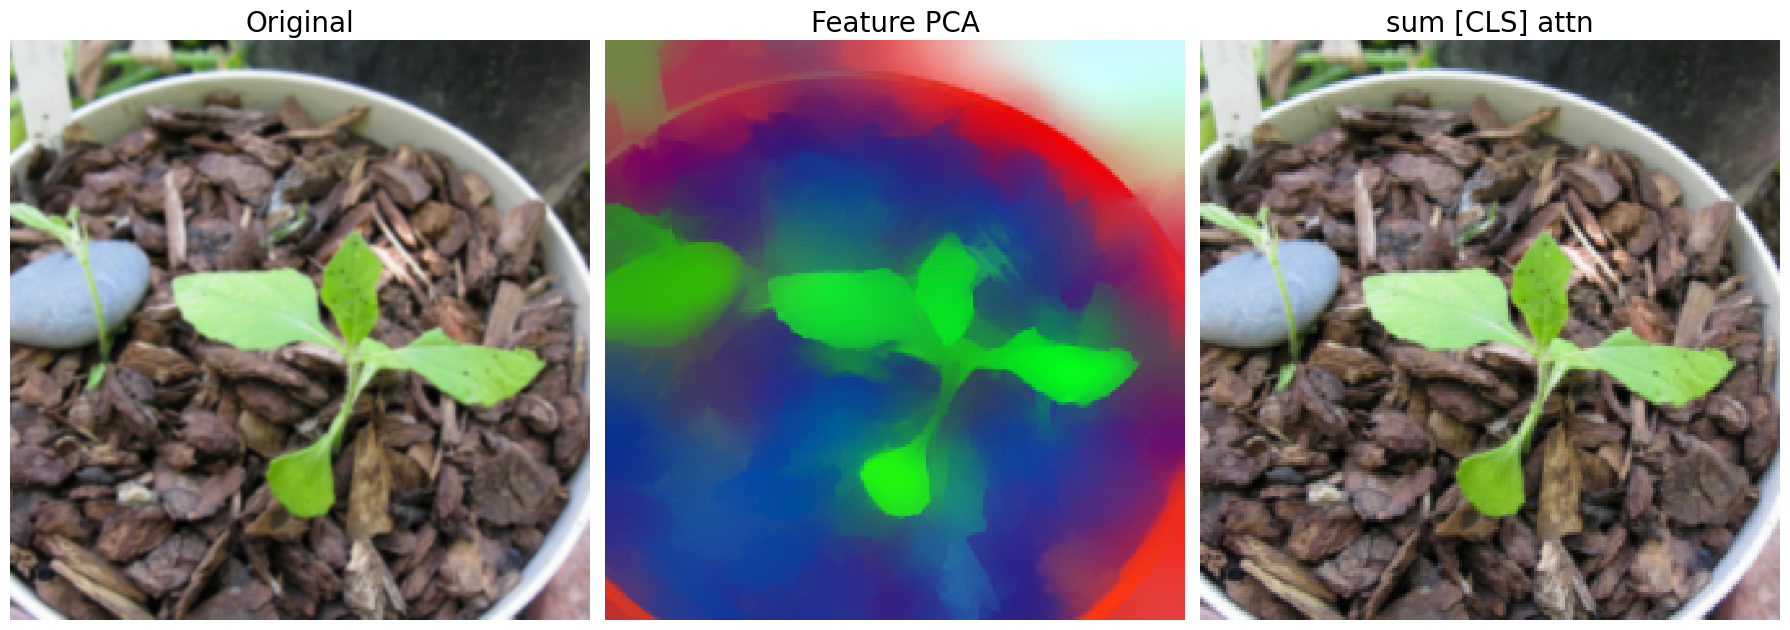

In [42]:
fig, axs = plt.subplots(nrows=1, ncols=3)
fig.set_size_inches(18, 8)

axs[0].imshow(img_arr)
axs[1].imshow(rescaled.reshape(224, 224, 3), interpolation='nearest')
axs[2].imshow(img_arr , interpolation='nearest')

titles = ["Original", "Feature PCA", "sum [CLS] attn"]
for i, ax in enumerate(axs):
    ax.set_axis_off()
    ax.set_title(titles[i], fontsize=20)
plt.tight_layout()